In [2]:
import os
import time

import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras import layers, models, optimizers
from keras.utils import get_file

import tensorflow_io as tfio

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import scipy.signal as signal

# tf.config.run_functions_eagerly(True)

In [3]:
# Load the data

os.chdir('C:\LELEC210X\LELEC210X')

"""
_ = get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)
"""

"\n_ = get_file('esc-50.zip',\n                        'https://github.com/karoldvl/ESC-50/archive/master.zip',\n                        cache_dir='./',\n                        cache_subdir='datasets',\n                        extract=True)\n"

In [4]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=10200)
    return wav

In [5]:
# Current path of the file
curDir = str(os.getcwd())

esc50_csv = curDir+'\classification\src\classification\datasets\ESC-50\meta\esc50.csv'
base_data_path = 'classification/src/classification/datasets/ESC-50/audio'

pd_data = pd.read_csv(esc50_csv)

my_classes = ['chirping_birds', 'chainsaw', 'crackling_fire', 'helicopter', 'hand_saw', 'fireworks']
map_class_to_id  = {label: idx for idx, label in enumerate(my_classes)}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]
unknown_pd = pd_data[~pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

unknown_pd = unknown_pd.assign(target=5)

# reduce the number of unknown samples to balance the dataset

unknown_pd = unknown_pd.sample(frac=40/1800, random_state=int(time.time()))
"""
filtered_pd = pd.concat([filtered_pd, unknown_pd])
"""
full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

my_classes = ['chirping_birds', 'chainsaw', 'crackling_fire', 'helicopter', 'hand_saw', 'fireworks']

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


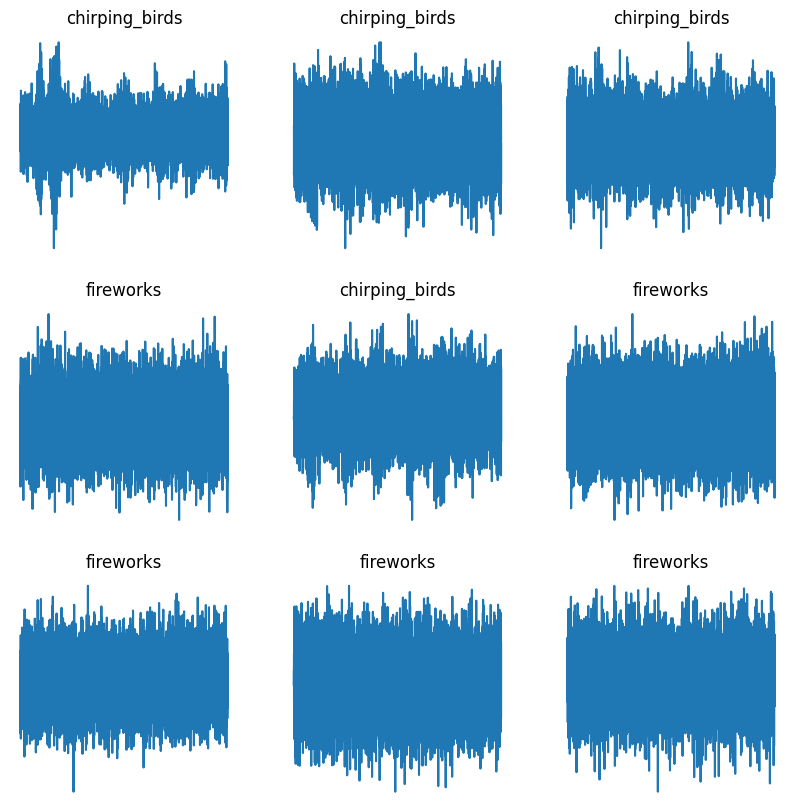

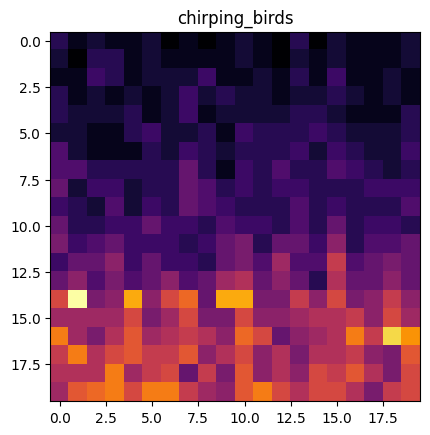

[[[ 3]
  [ 1]
  [ 2]
  [ 1]
  [ 1]
  [ 2]
  [ 0]
  [ 1]
  [ 0]
  [ 1]
  [ 2]
  [ 1]
  [ 0]
  [ 3]
  [ 0]
  [ 2]
  [ 1]
  [ 1]
  [ 1]
  [ 2]]

 [[ 2]
  [ 0]
  [ 3]
  [ 3]
  [ 1]
  [ 2]
  [ 1]
  [ 1]
  [ 1]
  [ 1]
  [ 2]
  [ 1]
  [ 0]
  [ 2]
  [ 1]
  [ 2]
  [ 1]
  [ 1]
  [ 1]
  [ 2]]

 [[ 1]
  [ 1]
  [ 4]
  [ 3]
  [ 1]
  [ 2]
  [ 2]
  [ 2]
  [ 4]
  [ 1]
  [ 1]
  [ 2]
  [ 1]
  [ 3]
  [ 1]
  [ 4]
  [ 1]
  [ 1]
  [ 2]
  [ 1]]

 [[ 3]
  [ 1]
  [ 2]
  [ 1]
  [ 2]
  [ 1]
  [ 2]
  [ 4]
  [ 2]
  [ 3]
  [ 2]
  [ 2]
  [ 1]
  [ 2]
  [ 2]
  [ 3]
  [ 2]
  [ 1]
  [ 2]
  [ 1]]

 [[ 3]
  [ 2]
  [ 2]
  [ 2]
  [ 3]
  [ 1]
  [ 2]
  [ 4]
  [ 1]
  [ 2]
  [ 2]
  [ 2]
  [ 2]
  [ 3]
  [ 3]
  [ 2]
  [ 1]
  [ 1]
  [ 1]
  [ 3]]

 [[ 2]
  [ 2]
  [ 1]
  [ 1]
  [ 3]
  [ 4]
  [ 2]
  [ 2]
  [ 3]
  [ 1]
  [ 4]
  [ 3]
  [ 3]
  [ 3]
  [ 4]
  [ 3]
  [ 2]
  [ 2]
  [ 2]
  [ 3]]

 [[ 5]
  [ 2]
  [ 1]
  [ 1]
  [ 1]
  [ 3]
  [ 2]
  [ 4]
  [ 3]
  [ 2]
  [ 3]
  [ 3]
  [ 3]
  [ 4]
  [ 2]
  [ 4]
  [ 3]
  [ 2]
  [ 2]
  [ 4]]

 [[ 5]

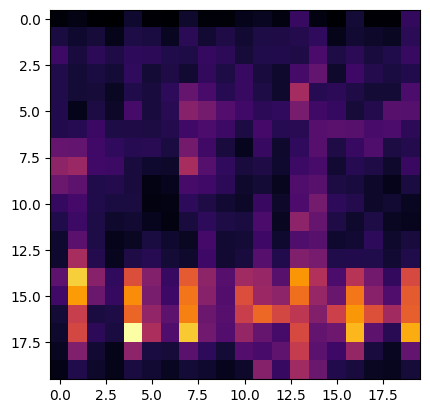

[[1.52587891e-04 2.74658203e-04 6.10351562e-05 3.05175781e-05
  6.10351562e-04 1.22070312e-04 6.10351562e-05 5.79833984e-04
  1.52587891e-04 1.52587891e-04 3.66210938e-04 4.57763672e-04
  2.44140625e-04 1.25122070e-03 2.44140625e-04 6.10351562e-05
  7.01904297e-04 1.22070312e-04 1.22070312e-04 1.19018555e-03]
 [7.93457031e-04 6.10351562e-04 7.32421875e-04 3.35693359e-04
  8.54492188e-04 7.93457031e-04 4.57763672e-04 1.06811523e-03
  6.40869141e-04 8.85009766e-04 6.71386719e-04 8.54492188e-04
  8.85009766e-04 9.76562500e-04 1.15966797e-03 3.35693359e-04
  6.40869141e-04 5.49316406e-04 4.88281250e-04 1.06811523e-03]
 [1.34277344e-03 7.62939453e-04 1.09863281e-03 8.85009766e-04
  1.12915039e-03 1.09863281e-03 9.15527344e-04 8.54492188e-04
  1.22070312e-03 1.09863281e-03 7.32421875e-04 9.15527344e-04
  9.46044922e-04 8.85009766e-04 1.55639648e-03 8.54492188e-04
  1.06811523e-03 7.62939453e-04 9.15527344e-04 1.25122070e-03]
 [9.15527344e-04 7.01904297e-04 7.93457031e-04 7.01904297e-04
  1.1

In [6]:
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

@tf.function
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)

@tf.function
def apply_time_shift(wav, label, fold):
  shift = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(wav)[0] - 20*512, dtype=tf.int32)
  return wav[shift:shift+20*512], label, fold

main_ds_time_shift_1 = main_ds.map(apply_time_shift)
main_ds_time_shift_2 = main_ds.map(apply_time_shift)
main_ds_time_shift_3 = main_ds.map(apply_time_shift)
main_ds_time_shift_4 = main_ds.map(apply_time_shift)

main_ds = tf.data.Dataset.zip((main_ds_time_shift_1, main_ds_time_shift_2)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))
main_ds = tf.data.Dataset.zip((main_ds, main_ds_time_shift_3)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))
main_ds = tf.data.Dataset.zip((main_ds, main_ds_time_shift_4)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))

@tf.function
def apply_bandpass(wav, label, fold):
  filter = signal.butter(10, [500, 5000], btype='bandpass', fs=10200, output='sos')
  wav = tf.numpy_function(lambda x: signal.sosfilt(filter, x).astype(np.float32), [wav], tf.float32)
  return wav, label, fold

# main_ds_bandpass = main_ds.map(apply_bandpass)
# main_ds = tf.data.Dataset.zip((main_ds, main_ds_bandpass)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))

@tf.function
def apply_noise(wav, label, fold):
  noise = tf.random.normal(tf.shape(wav), stddev=0.05)
  return wav + noise, label, fold

main_ds = main_ds.map(apply_noise)

# plot the first 9 waveforms with time shift

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (wav, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.plot(wav.numpy())
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()


# apply a melspectrogram transformation to the audio data

@tf.function
def wav2spec(wav, label, fold):
  spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=256, stride=512)
  mel_spectrogram = tfio.audio.melscale(spectrogram, rate=10200, mels=20, fmin=0, fmax=5100)
  mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)  # Ensure 3 dimensions
  mel_spectrogram = tf.image.rot90(mel_spectrogram, k=-1)
  return mel_spectrogram, label, fold

main_ds = main_ds.map(wav2spec)

@tf.function
def float_to_quint16(spec, label, fold):
  return tf.cast(spec, tf.uint16), label, fold

main_ds = main_ds.map(float_to_quint16)

# plot the first 9 spectrograms

spec, label, fold = next(iter(main_ds.take(1)))
plt.imshow(spec.numpy(), cmap='inferno')
plt.title(my_classes[label.numpy()])
plt.show()

print(spec.numpy())

"""
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (spec, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.imshow(spec.numpy(), cmap='inferno')
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()
"""
file1 = np.load("classification/data/melspecs/0005001a00.npy")
plt.imshow(file1.reshape(20, 20), cmap='inferno')
plt.show()

print(file1.reshape(20, 20))

# split the dataset into training and validation sets

@tf.function
def is_validation(fold):
  return fold == 1

@tf.function
def is_test(fold):
  return fold == 2

train_ds = main_ds.filter(lambda wav, label, fold: not is_validation(fold) and not is_test(fold))
val_ds = main_ds.filter(lambda wav, label, fold: is_validation(fold))
test_ds = main_ds.filter(lambda wav, label, fold: is_test(fold))

# shuffle the training dataset

train_ds = train_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

# batch the datasets

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

# prepare the datasets for training

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:

# build the model

def build_model(input_shape):
  model = models.Sequential()
  model.add(layers.Input(shape=input_shape, dtype=tf.quint16))
  model.add(layers.Normalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='leaky_relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(6, activation='softmax'))
  return model

input_shape = (20, 20, 1)

model = build_model(input_shape)

# compile the model

model.compile(optimizer=optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'], 
              weighted_metrics=[])

model_path = r'C:\LELEC210X\LELEC210X\classification\data\models\four.keras'

model = models.load_model(model_path)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 20, 20, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 9, 9, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 128)       

In [ ]:
# train the model

history = model.fit(train_ds, validation_data=val_ds, epochs=30, use_multiprocessing=True)

model.save(model_path)

# evaluate the model

loss, accuracy = model.evaluate(test_ds)

print(f'Test accuracy: {accuracy}')

# plot the confusion matrix

y_true = []
y_pred = []

for x, y, _ in test_ds:
  y_true.extend(y)
  y_pred.extend(model.predict(x).argmax(axis=1))
  
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# plot the training history

fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Plot the training history
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_title('Training and Validation Accuracy')

# Plot the confusion matrix
heatmap(cm, annot=True, xticklabels=my_classes, yticklabels=my_classes, ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

Epoch 1/30
6/6 [==============================] - 19s 2s/step - loss: 2.7600 - accuracy: 0.6786 - val_loss: 1.1306 - val_accuracy: 0.5365
Epoch 2/30
6/6 [==============================] - 14s 1s/step - loss: 2.9021 - accuracy: 0.6726 - val_loss: 1.0318 - val_accuracy: 0.6042
Epoch 3/30
6/6 [==============================] - 13s 1s/step - loss: 3.3444 - accuracy: 0.6607 - val_loss: 0.9627 - val_accuracy: 0.6406
Epoch 4/30
6/6 [==============================] - 14s 1s/step - loss: 3.0628 - accuracy: 0.6845 - val_loss: 1.0558 - val_accuracy: 0.6042
Epoch 5/30
6/6 [==============================] - 16s 2s/step - loss: 2.7479 - accuracy: 0.7024 - val_loss: 1.1194 - val_accuracy: 0.6354
Epoch 6/30
6/6 [==============================] - 15s 1s/step - loss: 2.8575 - accuracy: 0.6786 - val_loss: 1.1852 - val_accuracy: 0.5573
Epoch 7/30
6/6 [==============================] - 16s 1s/step - loss: 3.1020 - accuracy: 0.6667 - val_loss: 1.1879 - val_accuracy: 0.5365
Epoch 8/30
6/6 [==================

In [ ]:
fm_dir = "classification/data/feature_matrices/"

file1 = np.load(fm_dir + "../melspecs/0005001a00.npy")
file2 = np.load(fm_dir + "../melspecs/0002001900.npy")
file3 = np.load(fm_dir + "../melspecs/0004001500.npy")
file4 = np.load(fm_dir + "../melspecs/0004001900.npy")
file5 = np.load(fm_dir + "../melspecs/0005000700.npy")
file6 = np.load(fm_dir + "../melspecs/0005001200.npy")
file7 = np.load(fm_dir + "../melspecs/0005002200.npy")
file8 = np.load(fm_dir + "../melspecs/0017002200.npy")
file9 = np.load(fm_dir + "../melspecs/0026000000.npy")

X_aug = []

X_aug.append(file1.reshape(20, 20, 1))
X_aug.append(file2.reshape(20, 20, 1))
X_aug.append(file3.reshape(20, 20, 1))
X_aug.append(file4.reshape(20, 20, 1))
X_aug.append(file5.reshape(20, 20, 1))
X_aug.append(file6.reshape(20, 20, 1))
X_aug.append(file7.reshape(20, 20, 1))
X_aug.append(file8.reshape(20, 20, 1))
X_aug.append(file9.reshape(20, 20, 1))

for i in range(len(X_aug)):
    X_aug[i] = X_aug[i][None, ...]

y_aug = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

y_pred = np.zeros(len(y_aug))

for i in range(len(y_aug)):
    y_pred[i] = model.predict(X_aug[i]).argmax(axis=1)
    print (y_pred)
  
cm = confusion_matrix(y_aug, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# plot the training history

# Plot the confusion matrix
heatmap(cm, annot=True, xticklabels=my_classes, yticklabels=my_classes)
plt.set_xlabel('Predicted')
plt.set_ylabel('True')
plt.set_title('Confusion Matrix')

plt.show()

NameError: name 'np' is not defined